In [25]:
# Figure: Optimality gap with respect of the iteration count (n). Varying the staleness (tau_max)

In [26]:
pip install control

In [27]:
import numpy as np
import numpy.random as rnd
import control
from control import dlqr
import matplotlib.pyplot as plt
import time
import random
import gc
from scipy.io import loadmat
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [28]:
def perturbe_matrices(nominal, M, mask, epsilon):

    A = []
    for i in range(M):
        if i == 0:
          noise = 0
        else:
          noise = random.uniform(0, epsilon)
        A.append(nominal + mask*noise)


    return A


def grad_zo(A, B, Q, R, K, r, m):
    nx = A.shape[0]
    nu = B.shape[1]
    K1 = []
    K2 = []
    cost_1 = []
    cost_2 = []
    grad = np.zeros((nu, nx))
    Ul=[]
    for l in range(m):

        U = np.random.randn(B.shape[1], A.shape[0])
        U = (U / np.linalg.norm(U))* r

        K1.append(K + U)
        K2.append(K - U)

        # Compute cost
        x_0 = np.random.normal(0.5, 1e-3, size=(1,nx))[0]
        cost_1.append(lqr_cost(A, B, Q, R, K1[-1], x_0))
        cost_2.append(lqr_cost(A, B, Q, R, K2[-1], x_0))
        Ul.append(U)

    for l in range(m):
        grad += ((nx * nu) / (2 * m * (r ** 2))) * (cost_1[l] - cost_2[l]) * Ul[l]

    return grad


def local_step(K,eta_l,r,m,A,B,Q,R):

    #Estimate the gradient
    grad_estimate = grad_zo(A, B, Q, R, K, r, m)

    #One-step PG
    K_tilde = K - eta_l*grad_estimate


    return K_tilde - K #return model update


def lqr_cost(A, B, Q, R, K, x_0):
        T = 100
        PK = Q.copy()
        for t in range(T + 1):
            PK = Q + K.T @ R @ K + (A - B @ K).T @ PK @ (A - B @ K)
        cost = x_0 @ PK @ x_0
        return cost


def simulate(A, B, K, T, x_0):
        x_t = x0.copy()
        states = [x_t]
        controls = []
        for i in range(T):
            u_t = - K @ x_t
            controls.append(u_t)
            x_t = A @ x_t + B @ u_t
            states.append(x_t)
        return states

$\textbf{System matrices:}$

In [29]:
#Nominal system matrices

A_0 = np.array([[ 1.22,  0.03, -0.02, -0.32],
              [ 0.01,  4.7 ,  0.  ,  0.  ],
              [ 0.02, -0.06,  0.4 ,  0.  ],
              [ 0.01, -0.04,  0.72,  1.55]])

B_0 = np.array([[ 0.01,  0.99],
              [-3.44,  1.66],
              [-0.83,  0.44],
              [-0.47,  0.25]])

#Modification patterns
A_tilde = np.diag([1,2,3,4])
B_tilde = np.ones((4,2))
Q_tilde = np.diag([2,2,2,2])
R_tilde = np.diag([2,2])

nx = A_0.shape[0]
nu = B_0.shape[1]

Q_0 = np.eye(nx)
R_0 = np.eye(nu)

x_0 = np.array([0.25,0.55,0.35,0.45])

#Generate M tuples (Ai,Bi,Qi,Ri) according to the heterogeneity level (eps_A,eps_B,eps_Q,eps_R)

M = 100

epsilon_A = 0.01
A = perturbe_matrices(A_0, M, A_tilde, epsilon_A)

epsilon_B = 0.01
B = perturbe_matrices(B_0, M, B_tilde, epsilon_B)

epsilon_Q = 0.01
Q = perturbe_matrices(Q_0, M, Q_tilde, epsilon_Q)

epsilon_R = 0.01
R = perturbe_matrices(R_0, M, R_tilde, epsilon_R)


#Checking the heterogeneity

norm_1 = []
norm_2 = []
norm_3 = []
norm_4 = []
for p in range(M):
    for s in range(M):
        norm_1.append(np.linalg.norm(A[p] - A[s]))
        norm_2.append(np.linalg.norm(B[p] - B[s]))
        norm_3.append(np.linalg.norm(Q[p] - Q[s]))
        norm_4.append(np.linalg.norm(R[p] - R[s]))

print(["eps_A=", max(norm_1)])
print(["eps_B=", max(norm_2)])
print(["eps_Q=", max(norm_3)])
print(["eps_R=", max(norm_4)])

['eps_A=', 0.054602794308271474]
['eps_B=', 0.02805350656949142]
['eps_Q=', 0.038772117516981286]
['eps_R=', 0.028213683899206716]


$\textbf{Initial Stabilizing Controller:}$

In [30]:
K_opt_nominal,_,_ = dlqr(A_0, B_0, Q_0, R_0)
cost_opt_nominal = lqr_cost(A_0, B_0, Q_0, R_0, K_opt_nominal, x_0)

#Perturbing K_opt_nominal to generate an initial stabilizing controllers for all the M systems

K_0 = np.array([[ 0.33683197, -1.7417071 ,  0.15033713,  0.28966262],
               [ 0.68460759,  0.42031008, -0.28415275, -0.6531542 ]])
cost_init = lqr_cost(A_0, B_0, Q_0, R_0, K_0, x_0)

print(["cost_opt=", cost_opt_nominal])
print(["cost_init=", cost_init])

['cost_opt=', 2.7147945921976557]
['cost_init=', 4.062822450452139]


In [31]:
print(["K0",K_0])

['K0', array([[ 0.33683197, -1.7417071 ,  0.15033713,  0.28966262],
       [ 0.68460759,  0.42031008, -0.28415275, -0.6531542 ]])]


In [32]:
#Checking if K_0 stabilizes all the M systems
flag = 0
for i in range(M):
    if sum([abs_eig > 1 for abs_eig in abs(LA.eigvals(A[i] - B[i]@K_0))]):
        assert False
        flag = 1
if flag == 0:
    print("K0 stabilizes all M systems")

K0 stabilizes all M systems


$\textbf{Asynchronous LQR design:}$

In [33]:
def async_LQR(A,B,Q,R,K_0,eta_l,eta_g,N,bs,r,m,x_0,stragglers,tau_max):

    #free up memory
    gc.collect()

    gap = []

    #Iteration and buffer counters:

    s = 0
    n = 0

    M = len(A)

    cost_init = lqr_cost(A[0], B[0], Q[0], R[0], K_0, x_0)
    K_opt_nominal,_,_ = dlqr(A[0], B[0], Q[0], R[0])
    cost_opt_nominal = lqr_cost(A[0], B[0], Q[0], R[0], K_opt_nominal, x_0)
    gap.append(cost_init - cost_opt_nominal)
    print(f"Iteration: {0}, Cost gap: {gap[0]}")



    #Initialize the server
    K = K_0

    #Initialize local controllers
    Ks = []
    for i in range(M):
        Ks.append(K)

    flag_done = np.zeros((M,2))
    Deltas = []


    for i in range(M):
        Deltas.append(local_step(Ks[i],eta_l,r,m,A[i],B[i],Q[i],R[i]))



    indices = []

    #free up memory
    gc.collect()


    #Each system has its own counter

    times =[]

    for n in range(N):
        times.append(n)
        if gap[-1]<=0.3:
            break

        start_time = time.time()

        if n%tau_max != 0 :

            Delta = np.zeros((nu,nx))
            s = 0
            for i in range(M):
                if i not in stragglers:
                  Delta += Deltas[i]
                  s += 1
                  if s == bs:
                    break

            #Aggregate:
            K = K + eta_g*(1/bs)*Delta
            cost = lqr_cost(A[0], B[0], Q[0], R[0], K, x_0)
            gap.append(cost - cost_opt_nominal)
            end_time = time.time()
            print(f"Iteration: {n+1}, Cost gap: {gap[-1]}, Time: {end_time - start_time}")




            #Send the new controller to the clients that participate in the update

            for i in range(M):
              if i not in stragglers:

                 Ks[i] = K
                 Deltas[i] = local_step(Ks[i],eta_l,r,m,A[i],B[i],Q[i],R[i])


        else:
            Delta = np.zeros((nu,nx))
            s = 0
            for i in range(len(stragglers)):
                  Delta += Deltas[stragglers[i]]
                  s += 1
                  if s == bs:
                    break
            for i in range(M):
                if i not in stragglers:
                  Delta += Deltas[i]
                  s += 1
                  if s == bs:
                    break

            #Aggregate:
            K = K + eta_g*(1/bs)*Delta
            cost = lqr_cost(A[0], B[0], Q[0], R[0], K, x_0)
            gap.append(cost - cost_opt_nominal)
            end_time = time.time()
            print(f"Iteration: {n+1}, Cost gap: {gap[-1]}, Time: {end_time - start_time}")



            #Send the new controller to the clients that participate in the update

            for i in range(len(stragglers)):
                 Ks[stragglers[i]] = K
                 Deltas[stragglers[i]] = local_step(Ks[stragglers[i]],eta_l,r,m,A[stragglers[i]],B[stragglers[i]],Q[stragglers[i]],R[stragglers[i]])

        #eta_g = eta_g/1.05

    return gap,K ,times

$\textbf{Varying $\tau_{\max}$}$:

In [34]:
#Algorithm Parameters:

N = 100 #Number of iterations
eta_l = 1e-3 #local step-size
eta_g = 1e-2 #global step-size
r = 1e-4 #smoothing radius
m = 20 #number of trajectories
bs = 20 #buffer size

#number of seeds:
nseed = 1

#Max staleness
tau_max_vec = [1,3,10]

M = 50

stragglers = random.sample(range(1, M), 20)

gap_mean = []
gap_sd = []
gap_cint = []

times = []
for i in range(len(tau_max_vec)):
  tau_max = tau_max_vec[i]

  gap_seed = []
  for j in range(nseed):

    #free up memory
    gc.collect()
    gap, K_N, times_temp = async_LQR(A,B,Q,R,K_0,eta_l,eta_g,N,bs,r,m,x_0,stragglers,tau_max)
    gap_seed.append(gap)
    times.append(times_temp)

  gap_mean.append(np.mean(gap_seed,axis=0))
  gap_sd.append(np.std(gap_seed, axis = 0) / np.sqrt(len(gap_seed)))
  gap_cint.append(1.95*(np.std(gap_seed, axis = 0) / np.sqrt(len(gap_seed))))

Iteration: 0, Cost gap: 1.3480278582544836
Iteration: 1, Cost gap: 1.1488520822374353, Time: 0.0016531944274902344
Iteration: 2, Cost gap: 0.9876630547040959, Time: 0.001489877700805664
Iteration: 3, Cost gap: 0.8538476422643138, Time: 0.0015130043029785156
Iteration: 4, Cost gap: 0.7426375032231167, Time: 0.0015573501586914062
Iteration: 5, Cost gap: 0.6476782542003345, Time: 0.0014815330505371094
Iteration: 6, Cost gap: 0.5686868421057163, Time: 0.0015003681182861328
Iteration: 7, Cost gap: 0.5018796682261057, Time: 0.002711772918701172
Iteration: 8, Cost gap: 0.4456681679476966, Time: 0.001499176025390625
Iteration: 9, Cost gap: 0.39890900396070883, Time: 0.0014867782592773438
Iteration: 10, Cost gap: 0.3605997782278436, Time: 0.0015320777893066406
Iteration: 11, Cost gap: 0.3293955680027385, Time: 0.0016071796417236328
Iteration: 12, Cost gap: 0.3049497128599441, Time: 0.001562356948852539
Iteration: 13, Cost gap: 0.28688560677896824, Time: 0.0014667510986328125
Iteration: 0, Cost 

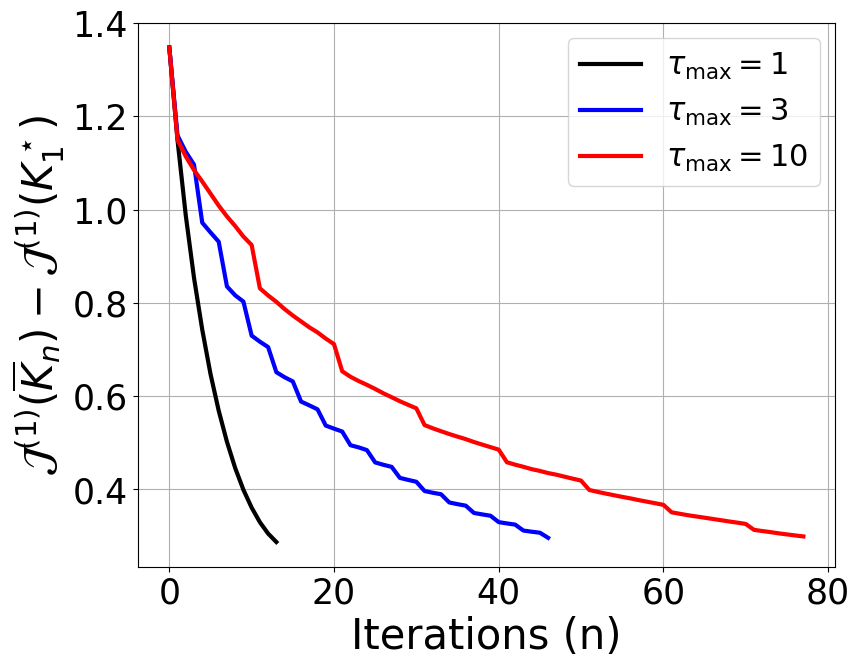

In [83]:
plt.figure(figsize=(9,8))


# Plotting the mean
colors = ['black', 'blue', 'red']
labels = [r"$\tau_{\max}=1$", r"$\tau_{\max}=3$", r"$\tau_{\max}=10$"]
plt.plot(times[0], gap_mean[0], label=labels[0], color=colors[0],linewidth=3)
plt.plot(times[1], gap_mean[1], label=labels[1], color=colors[1],linewidth=3)
plt.plot(times[2], gap_mean[2], label=labels[2], color=colors[2],linewidth=3)

plt.ylabel(r'$\mathcal{J}^{(1)}(\overline{K}_{n})-\mathcal{J}^{(1)}(K^\star_1)$',fontsize=30)
plt.xlabel('Iterations (n)',fontsize=30)
plt.tick_params(axis='both', labelsize=25)
#plt.semilogy()
plt.legend(fontsize="22")
# Exclude the shading elements from the legend
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:len(labels)]  # Keep only the handles for the curve lines
labels = labels[:len(labels)]  # Keep only the labels for the curve lines

# Exclude the shading elements from the legend
plt.subplots_adjust(bottom=0.20)
plt.grid()
plt.savefig('tau_max_opt_gap_arxiv.pdf')